# IMPORTS

In [1]:
# Clone the Git repository and navigate to the project directory
!git clone https://github.com/DanteMillerDS/NASA-Material-Classifier.git
%cd NASA-Material-Classifier

# Install required packages
!pip install xgboost
!pip install pytorch-tabnet
!pip install torch

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import torch
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mean_absolute_error
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold
from keras.layers import Bidirectional, LSTM, Dense
from sklearn.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetRegressor
import uuid

# Set random seeds for reproducibility
np.random.seed(1000)
tf.random.set_seed(1000)

Cloning into 'NASA-Material-Classifier'...
remote: Enumerating objects: 169, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 169 (delta 3), reused 17 (delta 2), pack-reused 150
Receiving objects: 100% (169/169), 231.02 MiB | 15.56 MiB/s, done.
Resolving deltas: 100% (43/43), done.
Updating files: 100% (67/67), done.
/content/NASA-Material-Classifier
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.6 MB/s eta 0:00:00


# PREPROCESSING

In [2]:
# Read training files
file_paths = dict()
for i in range(1, 21):
    file_path = [f"data/meteorite/simulated/sau_orientation{i}.txt"]
    file_paths[i] = file_path
def process_file(file_path,orientation):
    datasets = []
    with open(file_path, 'r') as file:
        current_dataset = []
        for line in file:

            if line.startswith("#Parameters"):
                if current_dataset:
                    datasets.append(current_dataset)
                    current_dataset = []
                params_str = line[line.index("{") + 1:line.index("}")]
                params = dict(param.split('=') for param in params_str.split(';'))
                current_dataset.append(params)
            elif "Frequency" in line:
              parts = line.split()
              s_number = parts[3][1:].replace(',', '')
              current_dataset.append(s_number)
            elif line.startswith("#"):
                continue
            else:
                data = line.strip().split('\t')
                current_dataset.append(data)
        if current_dataset:
            datasets.append(current_dataset)

    data = []
    for index, dataset in enumerate(datasets):
        permittivity_values = dataset[0]
        s_parameter_name = dataset[1]
        df_data = dataset[2:]
        df = pd.DataFrame(df_data, columns=["Frequency", f"{s_parameter_name}_Real", f"{s_parameter_name}_Imaginary"])
        df["Orientation"] = orientation
        df["ID"] = str(uuid.uuid4())[:8]
        for key, value in permittivity_values.items():
            if "er1" in key or "er11" in key:
                df[key] = value
        data.append(df)
    return data
all_combined_data = []
for index in file_paths:
    for file in file_paths[index]:
        combined_data = process_file(file,index)
        all_combined_data.append(combined_data)
array = []
for combined_data in all_combined_data:
  num_of_data = 4
  dataframes_length = int(len(combined_data)/num_of_data)
  for x in range(dataframes_length):
    concatenated_df = pd.DataFrame()
    for y in range(num_of_data):
      index = y * dataframes_length + x
      concatenated_df = pd.concat([concatenated_df, combined_data[index]], axis=1)
    concatenated_df = concatenated_df.loc[:,~concatenated_df.columns.duplicated()]
    array.append(concatenated_df)
training_dataframe = pd.concat(array, axis=0)
training_dataframe = training_dataframe.loc[:, ~training_dataframe.columns.duplicated()]

In [3]:
# Read testing files
file_paths = dict()
file_paths[0] = ["data/meteorite/actual/mea_sau008_0_orientation.txt"]
file_paths[1] = ["data/meteorite/actual/mea_sau008_90_oreintation.txt"]
file_paths[2] = ["data/meteorite/actual/mea_sau008_180_orientation.txt"]
file_paths[3] = ["data/meteorite/actual/mea_sau008_270_orientation.txt"]

def process_file(file_path,orientation):
    datasets = []
    with open(file_path, 'r') as file:
        current_dataset = []
        for line in file:

            if line.startswith("#Parameters"):
                if current_dataset:
                    datasets.append(current_dataset)
                    current_dataset = []
                params_str = line[line.index("{") + 1:line.index("}")]
                params = dict(param.split('=') for param in params_str.split(';'))
                current_dataset.append(params)
            elif "Frequency" in line:
              parts = line.split()
              s_number = parts[3][1:].replace(',', '')
              current_dataset.append(s_number)
            elif line.startswith("#"):
                continue
            else:
                data = line.strip().split('\t')
                current_dataset.append(data)
        if current_dataset:
            datasets.append(current_dataset)

    data = []
    for index, dataset in enumerate(datasets):
        permittivity_values = dataset[0]
        s_parameter_name = dataset[1]
        df_data = dataset[2:]
        df = pd.DataFrame(df_data, columns=["Frequency", f"{s_parameter_name}_Real", f"{s_parameter_name}_Imaginary"])
        df["Orientation"] = orientation
        df["ID"] = str(uuid.uuid4())[:8]
        for key, value in permittivity_values.items():
            if "er1" in key or "er11" in key:
                df[key] = value
        data.append(df)
    return data
all_combined_data = []
for index in file_paths:
    for file in file_paths[index]:
        combined_data = process_file(file,index)
        all_combined_data.append(combined_data)
array = []
for combined_data in all_combined_data:
  num_of_data = 4
  dataframes_length = int(len(combined_data)/num_of_data)
  for x in range(dataframes_length):
    concatenated_df = pd.DataFrame()
    for y in range(num_of_data):
      index = y * dataframes_length + x
      concatenated_df = pd.concat([concatenated_df, combined_data[index]], axis=1)
    concatenated_df = concatenated_df.loc[:,~concatenated_df.columns.duplicated()]
    array.append(concatenated_df)
testing_dataframe = pd.concat(array, axis=0)

In [4]:
# Print columns
print(training_dataframe.columns)
print(testing_dataframe.columns)

Index(['Frequency', 'S11_Real', 'S11_Imaginary', 'Orientation', 'ID', ' er1',
       ' er11', 'S21_Real', 'S21_Imaginary', 'S12_Real', 'S12_Imaginary',
       'S22_Real', 'S22_Imaginary'],
      dtype='object')
Index(['Frequency', 'S55_Real', 'S55_Imaginary', 'Orientation', 'ID', ' er1',
       ' er11', 'S65_Real', 'S65_Imaginary', 'S56_Real', 'S56_Imaginary',
       'S66_Real', 'S66_Imaginary'],
      dtype='object')


In [5]:
# Define variable names
training_dataframe.columns = ['Frequency', 'S11_Real', 'S11_Imaginary', 'Orientation', 'ID','Permittivity_Real', 'Permittivity_Imaginary', 'S21_Real',
       'S21_Imaginary', 'S12_Real', 'S12_Imaginary', 'S22_Real',
       'S22_Imaginary']
training_dataframe = training_dataframe[['ID','Frequency', 'Orientation', 'Permittivity_Real', 'Permittivity_Imaginary','S11_Real', 'S11_Imaginary', 'S12_Real',
       'S12_Imaginary', 'S21_Real', 'S21_Imaginary', 'S22_Real',
       'S22_Imaginary']]
testing_dataframe.columns = ['Frequency', 'S11_Real', 'S11_Imaginary', 'Orientation', 'ID','Permittivity_Real', 'Permittivity_Imaginary', 'S21_Real',
       'S21_Imaginary', 'S12_Real', 'S12_Imaginary', 'S22_Real',
       'S22_Imaginary']
testing_dataframe = testing_dataframe[['ID','Frequency', 'Orientation',  'Permittivity_Real', 'Permittivity_Imaginary','S11_Real', 'S11_Imaginary', 'S12_Real',
       'S12_Imaginary', 'S21_Real', 'S21_Imaginary', 'S22_Real',
       'S22_Imaginary']]

In [6]:
# Print variable names
training_dataframe.columns
testing_dataframe.columns

Index(['ID', 'Frequency', 'Orientation', 'Permittivity_Real',
       'Permittivity_Imaginary', 'S11_Real', 'S11_Imaginary', 'S12_Real',
       'S12_Imaginary', 'S21_Real', 'S21_Imaginary', 'S22_Real',
       'S22_Imaginary'],
      dtype='object')

In [7]:
# Drop na and applying numeric
training_dataframe.dropna(inplace=True)
columns = training_dataframe.columns[1:]
training_dataframe[columns] = training_dataframe[columns].apply(pd.to_numeric)
testing_dataframe.dropna(inplace=True)
testing_dataframe[columns] = testing_dataframe[columns].apply(pd.to_numeric)

In [8]:
# Remove id
training_dataframe = training_dataframe.iloc[:,1:]
testing_dataframe = testing_dataframe.iloc[:,1:]

In [9]:
# Set to 0.1
# testing_dataframe['Permittivity_Imaginary'][testing_dataframe['Permittivity_Imaginary'] == 0.4] = 0.1

In [10]:
# Describe training dataframe
training_dataframe.describe()

,Frequency,Orientation,Permittivity_Real,Permittivity_Imaginary,S11_Real,S11_Imaginary,S12_Real,S12_Imaginary,S21_Real,S21_Imaginary,S22_Real,S22_Imaginary
count,2.003001e+06,2.003001e+06,2.003001e+06,2.003001e+06,2.003001e+06,2.003001e+06,2.003001e+06,2.003001e+06,2.003001e+06,2.003001e+06,2.003001e+06,2.003001e+06
mean,1.350000e+00,1.049725e+01,4.945907e+00,4.963151e-02,-2.652006e-03,2.650201e-03,-5.381296e-02,-4.580618e-02,-5.381295e-02,-4.580618e-02,-8.480080e-03,4.908043e-04
std,2.022746e-01,5.766152e+00,2.278568e+00,2.886687e-02,1.036674e-01,1.060097e-01,7.054999e-01,6.794501e-01,7.054999e-01,6.794501e-01,1.009686e-01,1.083329e-01
min,1.000000e+00,1.000000e+00,1.000150e+00,1.707944e-04,-2.180810e-01,-2.549406e-01,-9.986315e-01,-9.962784e-01,-9.986316e-01,-9.962784e-01,-2.144937e-01,-2.509244e-01
25%,1.175000e+00,5.000000e+00,2.930578e+00,2.427854e-02,-8.970921e-02,-8.798371e-02,-7.518066e-01,-7.213721e-01,-7.518066e-01,-7.213721e-01,-9.131249e-02,-9.317510e-02
50%,1.350000e+00,1.000000e+01,4.984754e+00,4.901814e-02,-4.014916e-03,1.737387e-02,-1.561098e-01,-7.297147e-02,-1.561098e-01,-7.297142e-02,-1.472770e-02,1.168782e-02
75%,1.525000e+00,1.500000e+01,6.829293e+00,7.525355e-02,8.478236e-02,8.872819e-02,6.688859e-01,6.198645e-01,6.688859e-01,6.198645e-01,7.616111e-02,9.174016e-02
max,1.700000e+00,2.000000e+01,8.997784e+00,9.994916e-02,2.371261e-01,2.112861e-01,9.993030e-01,9.949554e-01,9.993030e-01,9.949554e-01,2.533520e-01,2.136576e-01


In [11]:
# Describe testing dataframe
testing_dataframe.describe()

,Frequency,Orientation,Permittivity_Real,Permittivity_Imaginary,S11_Real,S11_Imaginary,S12_Real,S12_Imaginary,S21_Real,S21_Imaginary,S22_Real,S22_Imaginary
count,4004.0000,4004.000000,4004.000000,4004.000000,4004.000000,4004.000000,4004.000000,4004.000000,4004.000000,4004.000000,4004.000000,4004.000000
mean,1.3500,1.500000,7.750000,0.430000,-0.008501,0.003331,0.959131,-0.202523,0.959105,-0.202242,0.008399,-0.001808
std,0.2023,1.118174,0.433067,0.337236,0.126175,0.122927,0.004006,0.013707,0.004028,0.013621,0.124165,0.124577
min,1.0000,0.000000,7.000000,0.120000,-0.229152,-0.201646,0.938142,-0.241066,0.937925,-0.240152,-0.185532,-0.211750
25%,1.1750,0.750000,7.750000,0.255000,-0.130663,-0.112173,0.957734,-0.210479,0.957669,-0.210197,-0.115633,-0.119994
50%,1.3500,1.500000,8.000000,0.300000,-0.013226,0.008739,0.960785,-0.200370,0.960799,-0.200090,0.020150,0.001122
75%,1.5250,2.250000,8.000000,0.475000,0.116752,0.121954,0.961649,-0.191734,0.961592,-0.191449,0.128447,0.119894
max,1.7000,3.000000,8.000000,1.000000,0.183352,0.187130,0.963593,-0.181735,0.963461,-0.181764,0.192772,0.184867


In [12]:
# Print training dataframe head
training_dataframe.head(5)

,Frequency,Orientation,Permittivity_Real,Permittivity_Imaginary,S11_Real,S11_Imaginary,S12_Real,S12_Imaginary,S21_Real,S21_Imaginary,S22_Real,S22_Imaginary
0,1.0000,1,1.092605,0.001191,0.099731,-0.037289,0.291348,0.942274,0.291348,0.942274,0.103373,-0.025510
1,1.0007,1,1.092605,0.001191,0.098817,-0.039333,0.310043,0.937010,0.310043,0.937010,0.102775,-0.027371
2,1.0014,1,1.092605,0.001191,0.097860,-0.041347,0.328585,0.931373,0.328586,0.931373,0.102141,-0.029213
3,1.0021,1,1.092605,0.001191,0.096864,-0.043331,0.346970,0.925367,0.346970,0.925367,0.101474,-0.031036
4,1.0028,1,1.092605,0.001191,0.095828,-0.045284,0.365189,0.919000,0.365189,0.919000,0.100772,-0.032841


In [13]:
# Print testing dataframe head
training_dataframe.head(5)

,Frequency,Orientation,Permittivity_Real,Permittivity_Imaginary,S11_Real,S11_Imaginary,S12_Real,S12_Imaginary,S21_Real,S21_Imaginary,S22_Real,S22_Imaginary
0,1.0000,1,1.092605,0.001191,0.099731,-0.037289,0.291348,0.942274,0.291348,0.942274,0.103373,-0.025510
1,1.0007,1,1.092605,0.001191,0.098817,-0.039333,0.310043,0.937010,0.310043,0.937010,0.102775,-0.027371
2,1.0014,1,1.092605,0.001191,0.097860,-0.041347,0.328585,0.931373,0.328586,0.931373,0.102141,-0.029213
3,1.0021,1,1.092605,0.001191,0.096864,-0.043331,0.346970,0.925367,0.346970,0.925367,0.101474,-0.031036
4,1.0028,1,1.092605,0.001191,0.095828,-0.045284,0.365189,0.919000,0.365189,0.919000,0.100772,-0.032841


# DATA VISUALIZATION

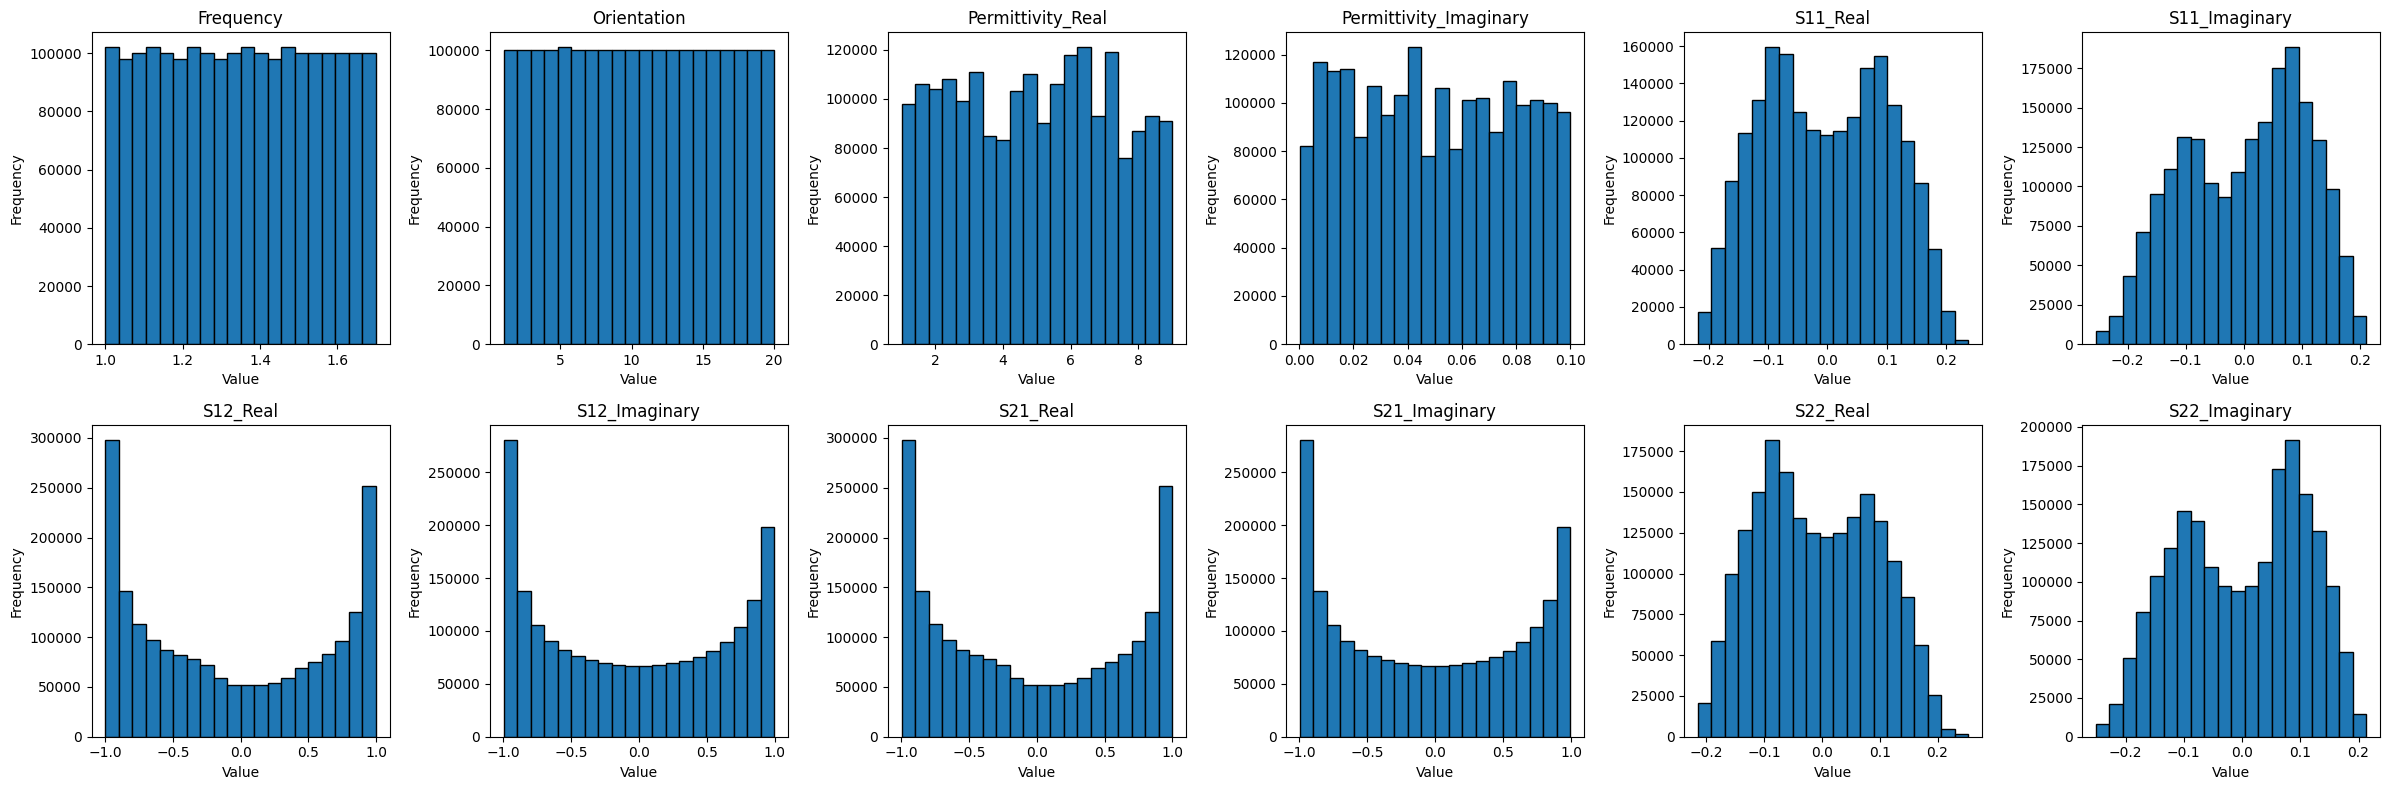

In [14]:
# Plot training dataframe columns
plt.figure(figsize=(24, 8))
for i, column in enumerate(training_dataframe.columns):
    plt.subplot(2,6 , i+1)
    plt.hist(training_dataframe[column], bins=20, edgecolor='black')
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

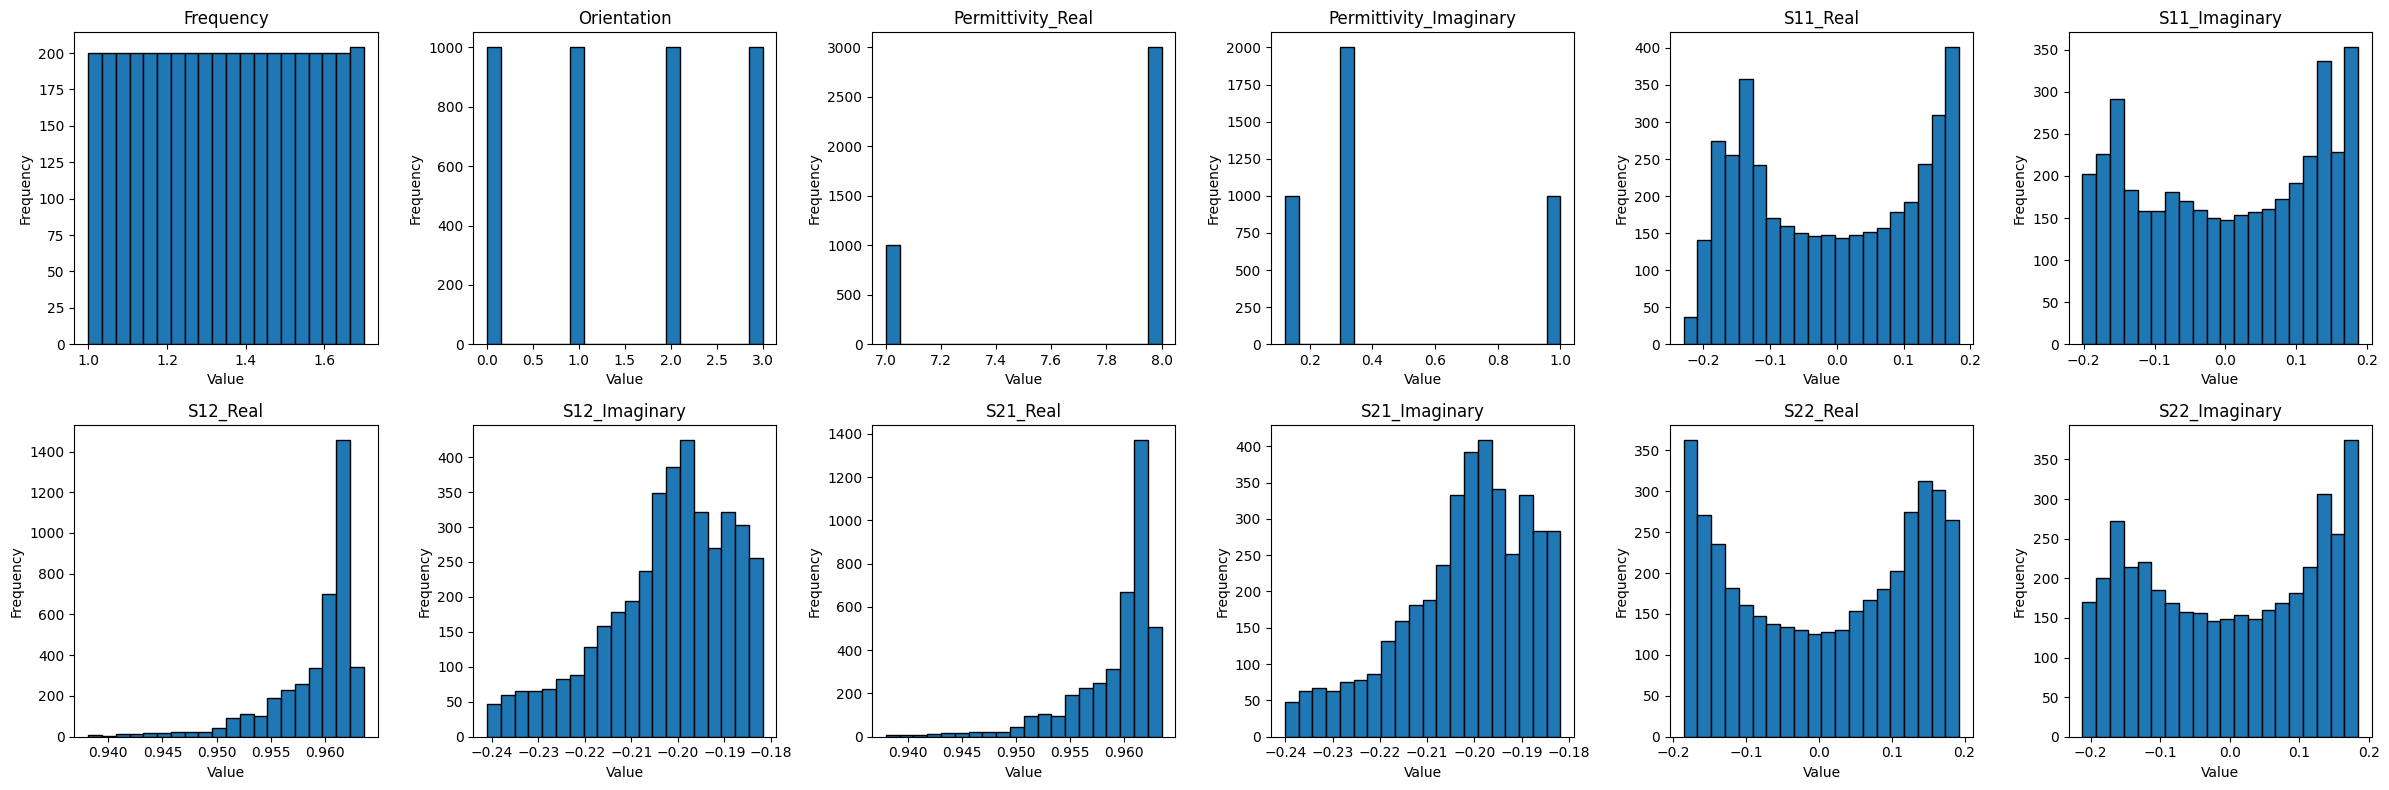

In [15]:
# Print testing dataframe columns
plt.figure(figsize=(24, 8))
for i, column in enumerate(testing_dataframe.columns):
    plt.subplot(2,6 , i+1)
    plt.hist(testing_dataframe[column], bins=20, edgecolor='black')
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [16]:
# Grabbing column means
columns = training_dataframe.columns[3:]
training_mean_predicted_values = training_dataframe.groupby('Frequency')[columns].mean()
testing_mean_predicted_values = testing_dataframe.groupby('Frequency')[columns].mean()

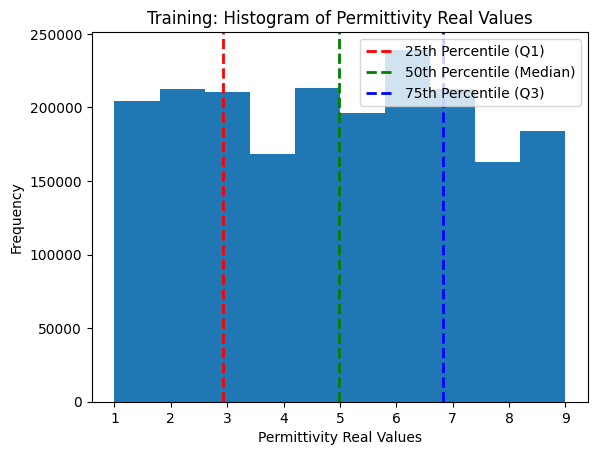

In [17]:
# Showing mean for the permittivity real training dataframe
q25 = np.percentile(training_dataframe["Permittivity_Real"], 25)
q50 = np.percentile(training_dataframe["Permittivity_Real"], 50)
q75 = np.percentile(training_dataframe["Permittivity_Real"], 75)
plt.hist(training_dataframe["Permittivity_Real"])
plt.xlabel("Permittivity Real Values")
plt.ylabel("Frequency")
plt.title("Training: Histogram of Permittivity Real Values")
plt.axvline(q25, color='red', linestyle='dashed', linewidth=2, label='25th Percentile (Q1)')
plt.axvline(q50, color='green', linestyle='dashed', linewidth=2, label='50th Percentile (Median)')
plt.axvline(q75, color='blue', linestyle='dashed', linewidth=2, label='75th Percentile (Q3)')
plt.legend()
plt.show()

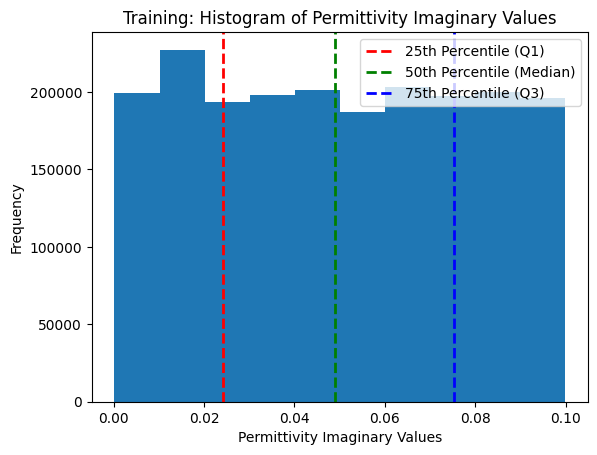

In [18]:
# Showing mean for the permittivity imaginary for training dataframe
q25 = np.percentile(training_dataframe["Permittivity_Imaginary"], 25)
q50 = np.percentile(training_dataframe["Permittivity_Imaginary"], 50)
q75 = np.percentile(training_dataframe["Permittivity_Imaginary"], 75)
plt.hist(training_dataframe["Permittivity_Imaginary"])
plt.xlabel("Permittivity Imaginary Values")
plt.ylabel("Frequency")
plt.title("Training: Histogram of Permittivity Imaginary Values")
plt.axvline(q25, color='red', linestyle='dashed', linewidth=2, label='25th Percentile (Q1)')
plt.axvline(q50, color='green', linestyle='dashed', linewidth=2, label='50th Percentile (Median)')
plt.axvline(q75, color='blue', linestyle='dashed', linewidth=2, label='75th Percentile (Q3)')
plt.legend()
plt.show()

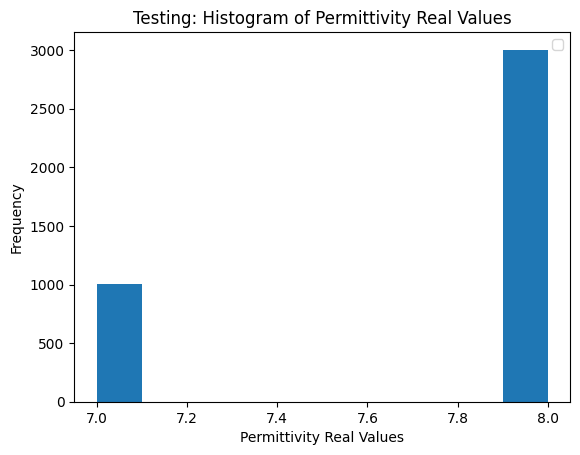

In [19]:
# Showing mean for the permittivity real for testing dataframe
plt.hist(testing_dataframe["Permittivity_Real"])
plt.xlabel("Permittivity Real Values")
plt.ylabel("Frequency")
plt.title("Testing: Histogram of Permittivity Real Values")
plt.legend()
plt.show()

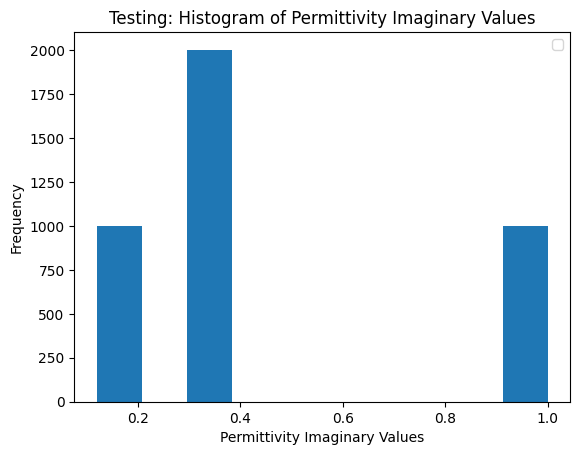

In [20]:
# Showing mean for the permittivity real for training dataframe
plt.hist(testing_dataframe["Permittivity_Imaginary"])
plt.xlabel("Permittivity Imaginary Values")
plt.ylabel("Frequency")
plt.title("Testing: Histogram of Permittivity Imaginary Values")
plt.legend()
plt.show()

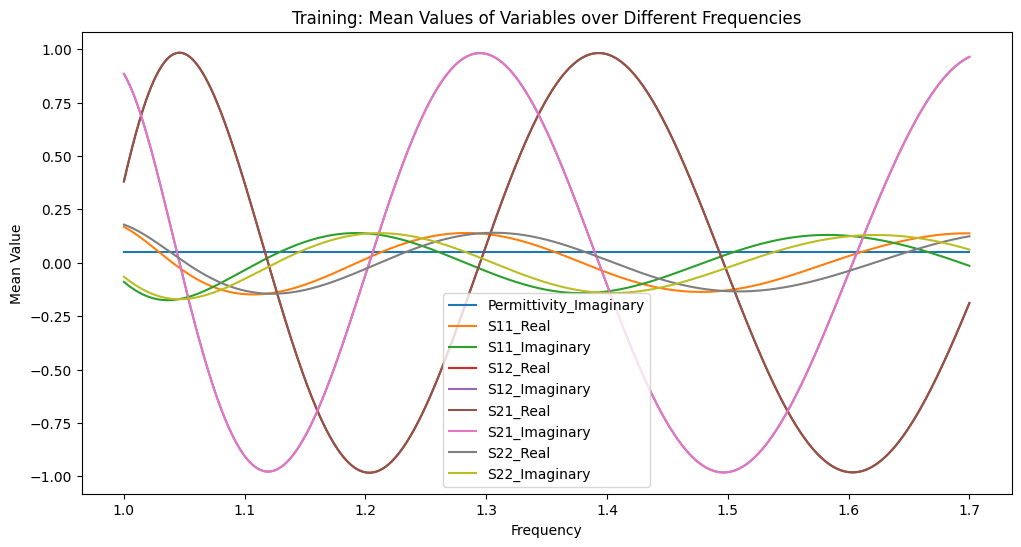

In [21]:
# Plot mean over frequencies for testing dataframe
plt.figure(figsize=(12, 6))
for col in training_mean_predicted_values.columns:
    plt.plot(training_mean_predicted_values.index, training_mean_predicted_values[col], label=col)
plt.xlabel('Frequency')
plt.ylabel('Mean Value')
plt.title('Training: Mean Values of Variables over Different Frequencies')
plt.legend()
plt.show()

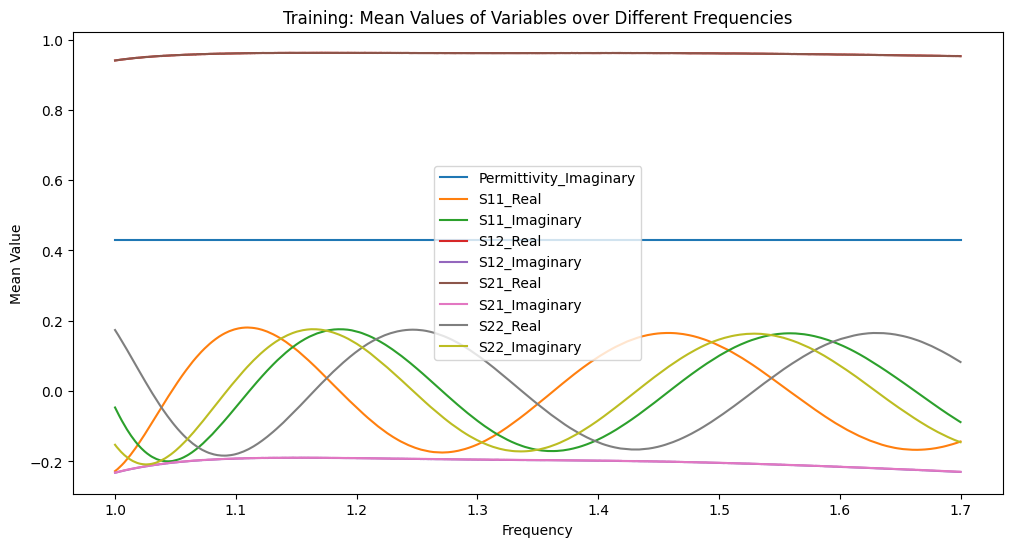

In [22]:
# Plot mean over frequencies for training dataframe
plt.figure(figsize=(12, 6))
for col in testing_mean_predicted_values.columns:
    plt.plot(testing_mean_predicted_values.index, testing_mean_predicted_values[col], label=col)
plt.xlabel('Frequency')
plt.ylabel('Mean Value')
plt.title('Training: Mean Values of Variables over Different Frequencies')
plt.legend()
plt.show()

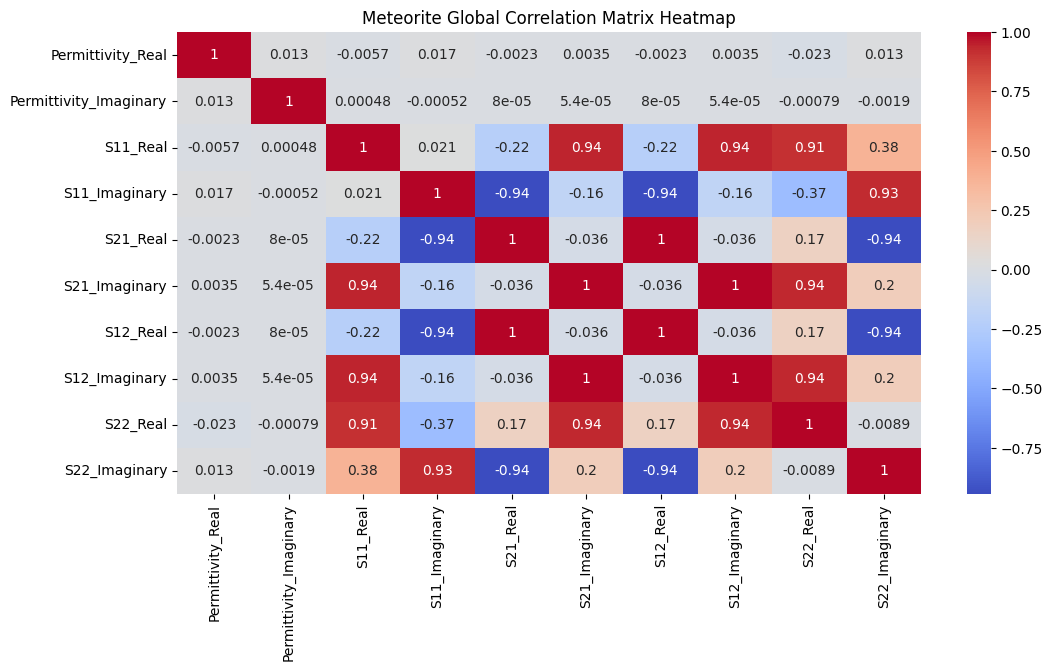

In [23]:
# Heatmap for global
plt.figure(figsize=(12, 6))
sns.heatmap(training_dataframe[['Permittivity_Real', 'Permittivity_Imaginary', 'S11_Real', 'S11_Imaginary', 'S21_Real','S21_Imaginary', 'S12_Real', 'S12_Imaginary', 'S22_Real','S22_Imaginary']].corr(), annot=True, cmap='coolwarm')
plt.title('Meteorite Global Correlation Matrix Heatmap')
plt.show()

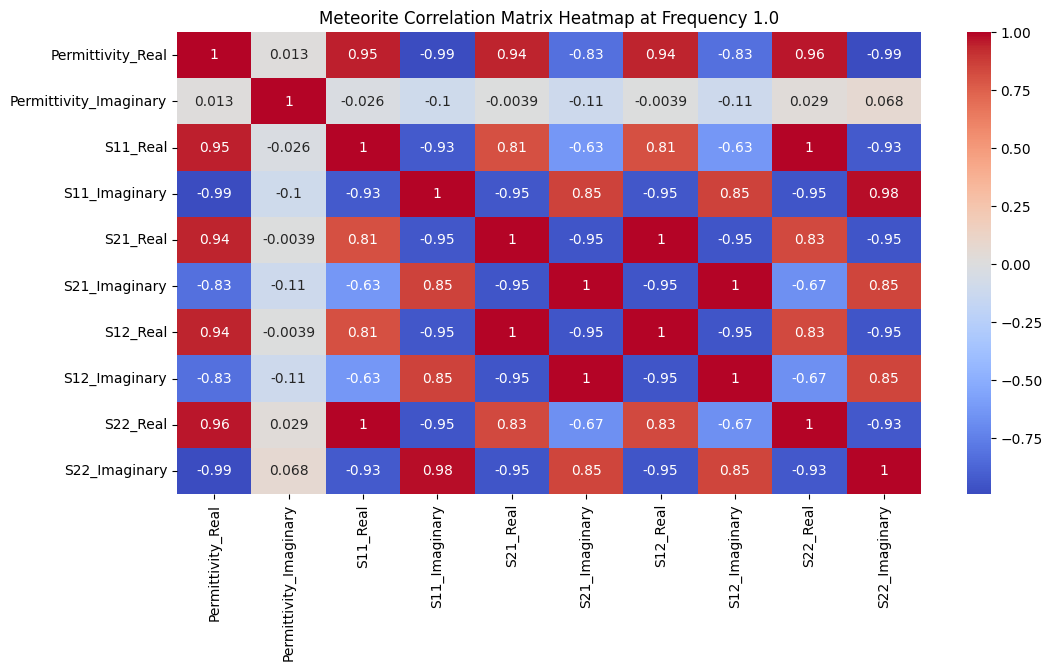

<Figure size 1200x600 with 0 Axes>

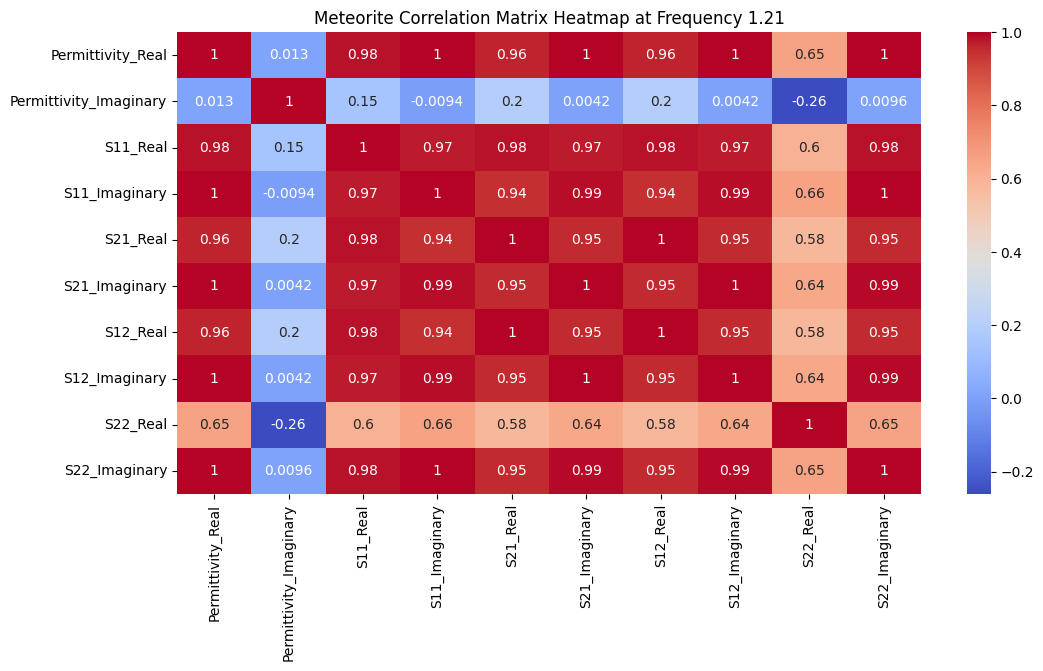

<Figure size 1200x600 with 0 Axes>

In [24]:
# Heatmap for various frequencies
unique_frequencies = np.unique(training_dataframe["Frequency"])
count = 0
for i in range(0, len(unique_frequencies), 300):
    if count < 2:
        plt.figure(figsize=(12, 6))
        sample = training_dataframe[training_dataframe["Frequency"] == unique_frequencies[i]]
        sns.heatmap(sample[['Permittivity_Real', 'Permittivity_Imaginary', 'S11_Real', 'S11_Imaginary', 'S21_Real', 'S21_Imaginary', 'S12_Real', 'S12_Imaginary', 'S22_Real', 'S22_Imaginary']].corr(), annot=True, cmap='coolwarm')
        plt.title(f'Meteorite Correlation Matrix Heatmap at Frequency {np.round(unique_frequencies[i],3)}')
        plt.figure(figsize=(12, 6))
        count += 1
    else:
        break

# DATA MANIPULATION

In [25]:
# Normalize
training_dataframe["Permittivity_Real"] /= 100
testing_dataframe["Permittivity_Real"] /= 100

In [26]:
# Power transform
no_id = [
 'S11_Real',
 'S11_Imaginary',
 'S12_Real',
 'S12_Imaginary',
 'S21_Real',
 'S21_Imaginary',
 'S22_Real',
 'S22_Imaginary']
bc = QuantileTransformer(random_state=42)
bc.fit(training_dataframe[no_id])
training_dataframe[training_dataframe[no_id].columns] = bc.transform(training_dataframe[no_id])
testing_dataframe[testing_dataframe[no_id].columns]  = bc.transform(testing_dataframe[no_id])

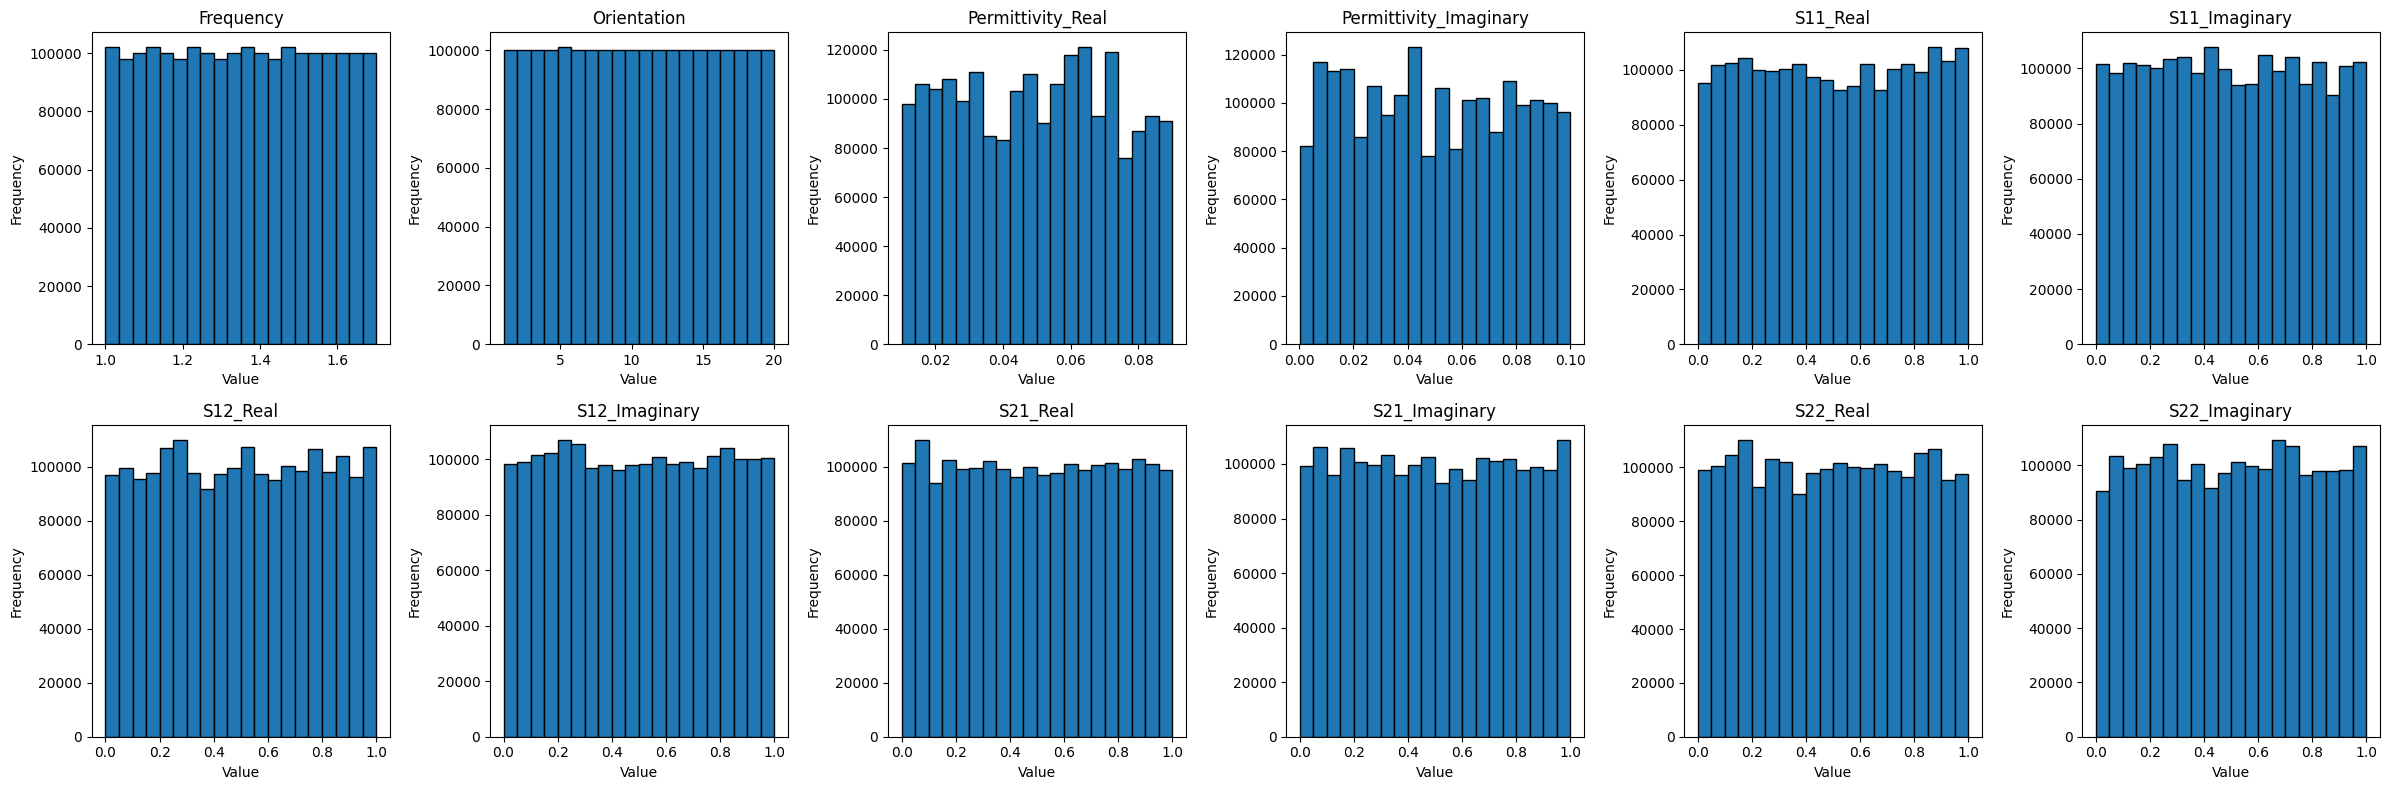

In [27]:
# Plot training histogram
plt.figure(figsize=(24, 8))
for i, column in enumerate(training_dataframe.columns):
    plt.subplot(2,6 , i+1)
    plt.hist(training_dataframe[column], bins=20, edgecolor='black')
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

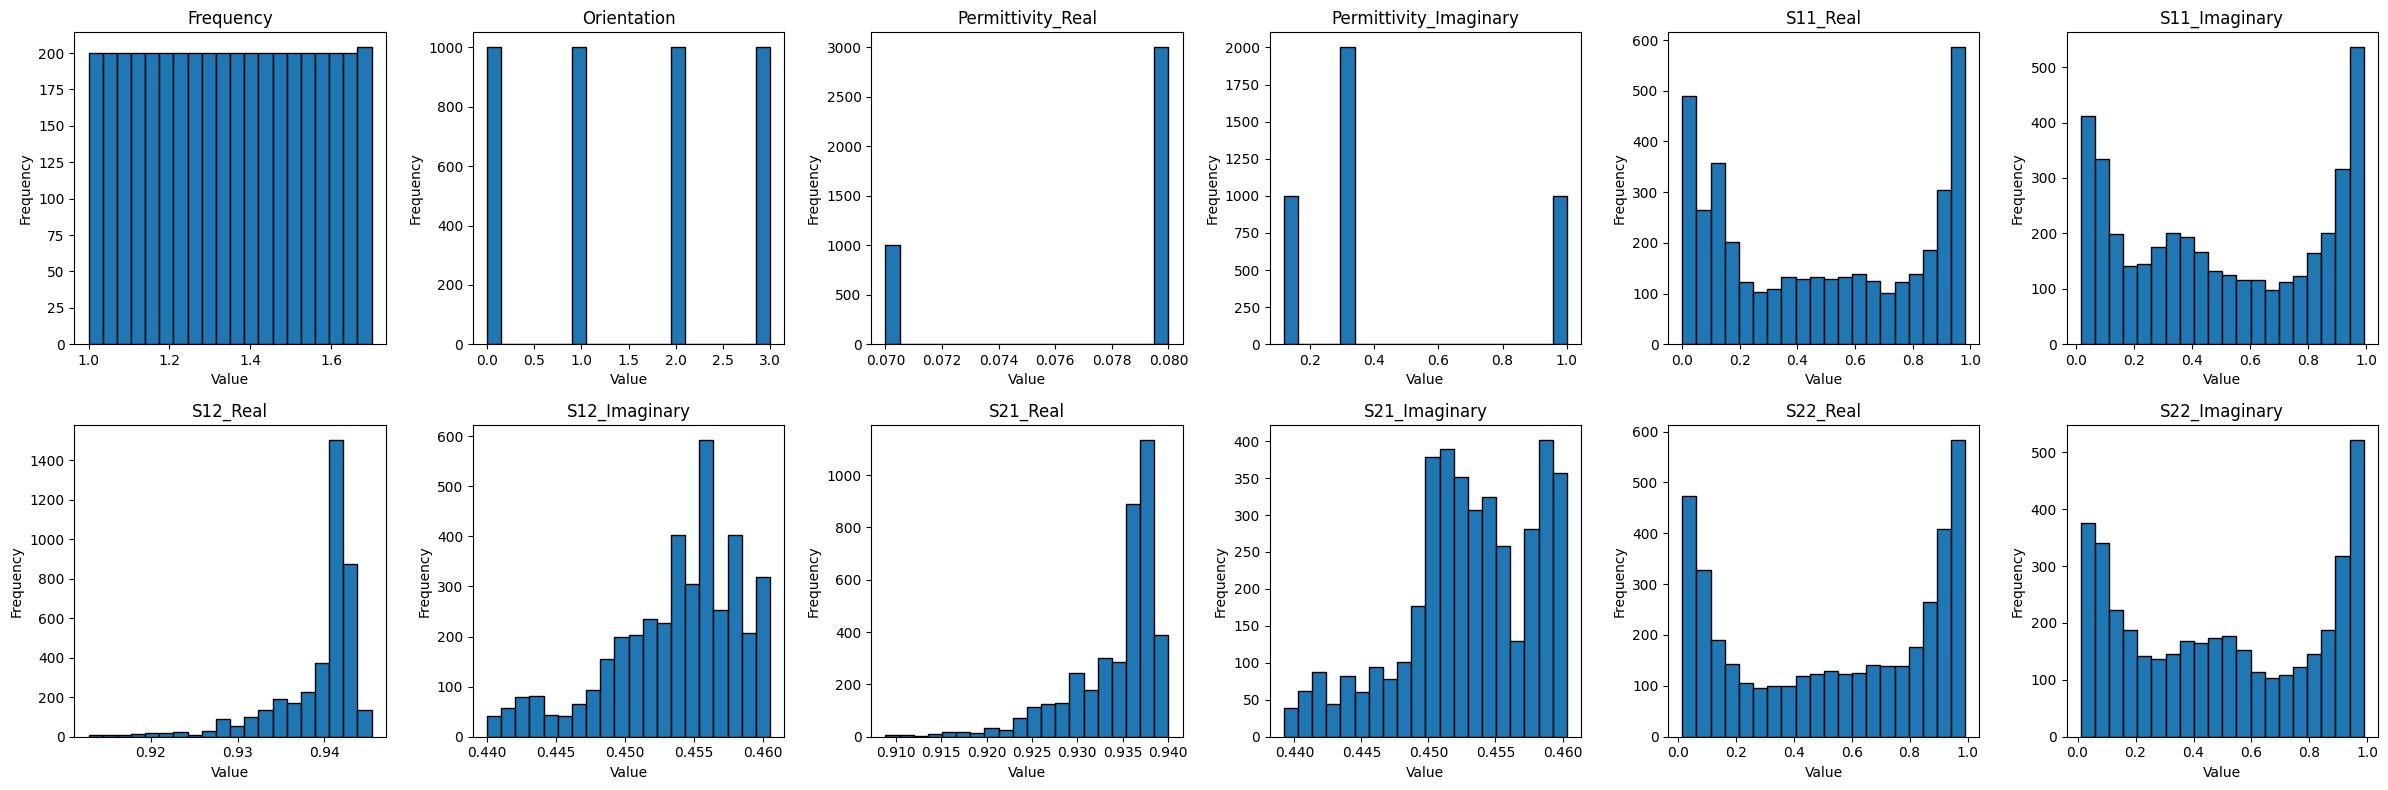

In [28]:
# Plot testing histogram
plt.figure(figsize=(24, 8))
for i, column in enumerate(testing_dataframe.columns):
    plt.subplot(2,6 , i+1)
    plt.hist(testing_dataframe[column], bins=20, edgecolor='black')
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# MODELS

In [29]:
# Hyperparameters
LR = 0.0001
L2 = 0.00001
WD = 0.000001

In [30]:
# Column names
columns = []
for column in training_dataframe.columns:
    if column not in ["Permittivity_Real","Permittivity_Imaginary","ID","Orientation","Frequency"]:
        columns.append(column)
columns

['S11_Real',
 'S11_Imaginary',
 'S12_Real',
 'S12_Imaginary',
 'S21_Real',
 'S21_Imaginary',
 'S22_Real',
 'S22_Imaginary']

In [31]:
# K fold
k_fold_value = 10
X_train = training_dataframe[columns].values
y_train = training_dataframe[['Permittivity_Real', 'Permittivity_Imaginary']].values
selected_indices = np.arange(len(training_dataframe))
grouped_indices = {}
for idx in selected_indices:
    row = training_dataframe.iloc[idx]
    orientation = row['Orientation']
    frequency = row['Frequency']
    key = (orientation, frequency)
    if key not in grouped_indices:
        grouped_indices[key] = []
    grouped_indices[key].append(idx)

X_train_indices = []
X_test_indices = []
for key, indices in grouped_indices.items():
    train_indices, test_indices = train_test_split(indices, test_size=0.1, random_state=42)
    X_train_indices.extend(train_indices)
    X_test_indices.extend(test_indices)
    grouped_indices[key] = train_indices
X_test_indices.sort()

X_selected = X_train
y_selected = y_train

# grouped_indices = {}
# for idx in selected_indices:
#     row = training_dataframe.iloc[idx]
#     orientation = row['Orientation']
#     frequency = row['Frequency']
#     key = (orientation, frequency)
#     if key not in grouped_indices:
#         grouped_indices[key] = []
#     grouped_indices[key].append(idx)
# kf = KFold(n_splits=5)
X_train_indices_dict = dict()
X_val_indices_dict = dict()
X_test_indices_dict = dict()
for i in range(k_fold_value):
  X_train_indices_dict[i] = []
  X_val_indices_dict[i] = []
  X_test_indices_dict[i] = X_test_indices

# for key, indices in grouped_indices.items():
#     for index, (train_indice_x, val_indice_x) in enumerate(kf.split(indices)):
#       train_indices = train_indice_x
#       val_indices = val_indice_x
#       X_train_indices_dict[index].extend(train_indices)
#       X_val_indices_dict[index].extend(val_indices)

# for i in range(5):
#   X_test_indices_dict[i].sort()

X_train_indices = []
X_val_indices = []
kf = KFold(n_splits=k_fold_value,shuffle=True,random_state=42)
for ind in range(k_fold_value):
  for key, indices in grouped_indices.items():
    train_indices,val_indices = list(kf.split(indices))[ind]
    train_indices = [indices[i] for i in train_indices]
    val_indices = [indices[i] for i in val_indices]
    X_train_indices_dict[ind].extend(train_indices)
    X_val_indices_dict[ind].extend(val_indices)
    # for index, (train_indices, val_indices) in enumerate(kf.split(indices)):
    #   #train_indices, val_indices = train_test_split(indices, test_size=0.1, random_state=100)
    #   X_train_indices.extend(train_indices)
    #   X_val_indices.extend(val_indices)

In [32]:
# Showing number of observations
num_obs_train = len(X_selected[X_train_indices_dict[0]])
num_obs_val = len(X_selected[X_val_indices_dict[0]])
num_obs_test = len(X_train[X_test_indices_dict[0]])
total_obs = num_obs_train + num_obs_val + num_obs_test
data = {'Dataset': ['Training', 'Validation', 'Test', 'Total'],
            'Number of Observations': [num_obs_train, num_obs_val, num_obs_test, total_obs]}
observations_table = pd.DataFrame(data)
print(observations_table)

      Dataset  Number of Observations
0    Training                 1621620
1  Validation                  180180
2        Test                  201201
3       Total                 2003001


In [33]:
# # Showing uniform orientations and frequencies
# selected_orientations = training_dataframe.loc[X_train_indices_dict[0], 'Orientation']
# selected_frequencies = training_dataframe.loc[X_train_indices_dict[0], 'Frequency']

# plt.figure(figsize=(15, 10))

# plt.subplot(2, 2, 1)
# plt.hist(selected_orientations, bins=10, color='blue', edgecolor='black')
# plt.title('Training: Histogram of Selected Orientations')
# plt.xlabel('Orientation')
# plt.ylabel('Frequency')

# plt.subplot(2, 2, 2)
# plt.hist(selected_frequencies, bins=20, color='green', edgecolor='black')
# plt.title('Training: Histogram of Selected Frequencies')
# plt.xlabel('Frequency')
# plt.ylabel('Frequency')

# plt.tight_layout()
# plt.show()

# selected_orientations = training_dataframe.loc[X_val_indices_dict[0], 'Orientation']
# selected_frequencies = training_dataframe.loc[X_val_indices_dict[0], 'Frequency']

# plt.figure(figsize=(15, 10))

# plt.subplot(2, 2, 1)
# plt.hist(selected_orientations, bins=10, color='blue', edgecolor='black')
# plt.title('Validation: Histogram of Selected Orientations')
# plt.xlabel('Orientation')
# plt.ylabel('Frequency')

# plt.subplot(2, 2, 2)
# plt.hist(selected_frequencies, bins=20, color='green', edgecolor='black')
# plt.title('Validation: Histogram of Selected Frequencies')
# plt.xlabel('Frequency')
# plt.ylabel('Frequency')

# plt.tight_layout()
# plt.show()

# selected_orientations = training_dataframe.loc[X_test_indices_dict[0], 'Orientation']
# selected_frequencies = training_dataframe.loc[X_test_indices_dict[0], 'Frequency']

# plt.figure(figsize=(15, 10))
# plt.subplot(2, 2, 1)
# plt.hist(selected_orientations, bins=10, color='blue', edgecolor='black')
# plt.title('Testing: Histogram of Selected Orientations')
# plt.xlabel('Orientation')
# plt.ylabel('Frequency')

# plt.subplot(2, 2, 2)
# plt.hist(selected_frequencies, bins=20, color='green', edgecolor='black')
# plt.title('Testing: Histogram of Selected Frequencies')
# plt.xlabel('Frequency')
# plt.ylabel('Frequency')

# plt.tight_layout()
# plt.show()

In [34]:
# Train models
def train_models(X_train,y_train,X_val,y_val):

    def rmse_loss(y_true, y_pred):
      squared_error = tf.square(y_true - y_pred)
      mean_squared_error = tf.reduce_mean(squared_error)
      root_mean_squared_error = tf.sqrt(mean_squared_error)
      return root_mean_squared_error

    nn_model = keras.Sequential([
        keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],),kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(L2)),
        keras.layers.Dense(64, activation='relu', kernel_initializer='he_uniform',kernel_regularizer=tf.keras.regularizers.l2(L2)),
        keras.layers.Dense(32, activation='relu', kernel_initializer='he_uniform',kernel_regularizer=tf.keras.regularizers.l2(L2)),
        keras.layers.Dense(16, activation='relu', kernel_initializer='he_uniform',kernel_regularizer=tf.keras.regularizers.l2(L2)),
        keras.layers.Dense(y_train.shape[1], activation='linear')
    ])


    nn_model.compile(optimizer=tf.optimizers.Adam(learning_rate=L2,weight_decay=WD),
                  loss=[rmse_loss],
                  metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError()])
    nn_model.summary()
    history = nn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50,shuffle=True,batch_size=1001)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['mean_absolute_error'])
    plt.plot(history.history['val_mean_absolute_error'])
    plt.title('FNN: Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend(['Train', 'Validation'])
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('FNN: Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'])
    plt.tight_layout()
    plt.show()

    xgb_model = xgb.XGBRegressor(n_jobs=-1,device="gpu",n_estimators=250,eval_metric="rmse",verbosity=3,max_depth=5)
    xgb_model.fit(X_train, y_train)

    X_train_tensor = torch.tensor(X_train , dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
    tabnet_model = TabNetRegressor(
    device_name="cuda"
    )
    tabnet_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        max_epochs=10,
        batch_size=1001,
        eval_metric=["rmse"]
    )
    return nn_model, xgb_model, tabnet_model
    #    optimizer_params={
   #         "lr": LR,  # Set your desired learning rate here
     #       "weight_decay": WD,  # Set your desired weight decay here
    #    }  # Use RMSE as the evaluation metric

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1152      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 2)                 34        
                                                                 
Total params: 12050 (47.07 KB)
Trainable params: 12050 (47.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
1620/1620

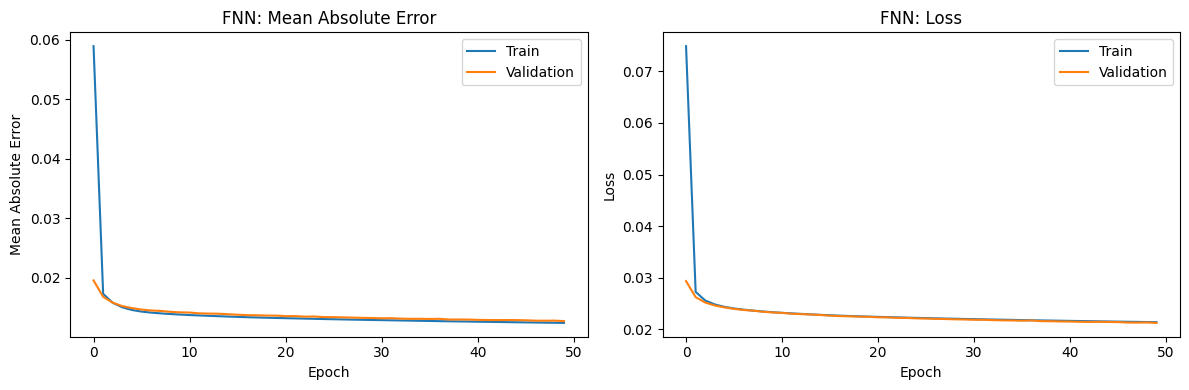

[19:50:51] ======== Monitor (0): HostSketchContainer ========
[19:50:51] AllReduce: 0.004891s, 1 calls @ 4891us

[19:50:51] MakeCuts: 0.004925s, 1 calls @ 4925us

[19:50:51] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[19:50:51] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:744: [GPU Hist]: Configure
[19:50:52] ======== Monitor (0):  ========
[19:50:52] InitCompressedData: 0.000828s, 1 calls @ 828us

[19:50:58] ======== Monitor (0): Learner ========
[19:50:58] Configure: 0.951061s, 1 calls @ 951061us

[19:50:58] EvalOneIter: 0.002059s, 250 calls @ 2059us

[19:50:58] GetGradient: 2.76983s, 250 calls @ 2769828us

[19:50:58] PredictRaw: 0.000728s, 250 calls @ 728us

[19:50:58] UpdateOneIter: 6.3954s, 250 calls @ 6395399us

[19:50:58] ======== Monitor (0): GBTree ========
[19:50:58] BoostNewTrees: 2.56867s, 250 calls @ 2568672us

[19:50:58] CommitModel: 0.000213s, 250 calls @ 213us

[19:50:58] ======== Device 0 Memory Allocations:  ========
[19:50:58] Peak memory usage: 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.00572 | val_0_rmse: 0.02278 |  0:01:25s
epoch 1  | loss: 0.00058 | val_0_rmse: 0.02193 |  0:02:52s
epoch 2  | loss: 0.00053 | val_0_rmse: 0.0219  |  0:04:17s
epoch 3  | loss: 0.00051 | val_0_rmse: 0.02181 |  0:05:44s
epoch 4  | loss: 0.0005  | val_0_rmse: 0.02187 |  0:07:10s
epoch 5  | loss: 0.0005  | val_0_rmse: 0.02173 |  0:08:36s
epoch 6  | loss: 0.00047 | val_0_rmse: 0.02219 |  0:10:01s
epoch 7  | loss: 0.00047 | val_0_rmse: 0.02151 |  0:11:26s
epoch 8  | loss: 0.00047 | val_0_rmse: 0.0215  |  0:12:51s
epoch 9  | loss: 0.00046 | val_0_rmse: 0.02133 |  0:14:16s
Stop training because you reached max_epochs = 10 with best_epoch = 9 and best_val_0_rmse = 0.02133


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 128)               1152      
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 16)                528       
                                                                 
 dense_9 (Dense)             (None, 2)                 34        
                                                                 
Total params: 12050 (47.07 KB)
Trainable params: 12050 (47.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
1620/16

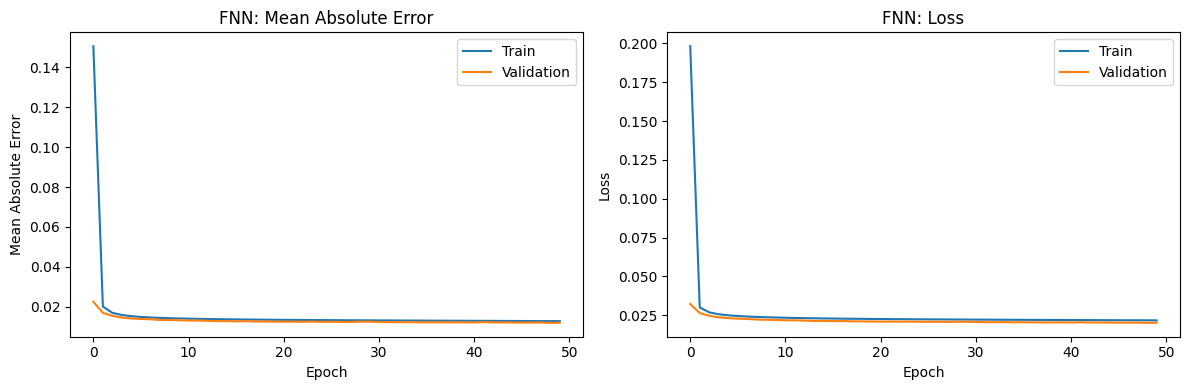

[20:17:12] ======== Monitor (0): HostSketchContainer ========
[20:17:12] AllReduce: 0.004982s, 1 calls @ 4982us

[20:17:12] MakeCuts: 0.005016s, 1 calls @ 5016us

[20:17:12] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[20:17:12] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:744: [GPU Hist]: Configure
[20:17:12] ======== Monitor (0):  ========
[20:17:12] InitCompressedData: 0.000356s, 1 calls @ 356us

[20:17:18] ======== Monitor (0): Learner ========
[20:17:18] Configure: 0.000812s, 1 calls @ 812us

[20:17:18] EvalOneIter: 0.001642s, 250 calls @ 1642us

[20:17:18] GetGradient: 2.86508s, 250 calls @ 2865083us

[20:17:18] PredictRaw: 0.000486s, 250 calls @ 486us

[20:17:18] UpdateOneIter: 5.53356s, 250 calls @ 5533560us

[20:17:18] ======== Monitor (0): GBTree ========
[20:17:18] BoostNewTrees: 2.56352s, 250 calls @ 2563525us

[20:17:18] CommitModel: 0.000154s, 250 calls @ 154us

[20:17:18] ======== Device 0 Memory Allocations:  ========
[20:17:18] Peak memory usage: 18

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.00552 | val_0_rmse: 0.02319 |  0:01:24s
epoch 1  | loss: 0.00061 | val_0_rmse: 0.0212  |  0:02:49s
epoch 2  | loss: 0.00056 | val_0_rmse: 0.02082 |  0:04:14s
epoch 3  | loss: 0.00052 | val_0_rmse: 0.02026 |  0:05:39s
epoch 4  | loss: 0.00052 | val_0_rmse: 0.02086 |  0:07:05s
epoch 5  | loss: 0.00049 | val_0_rmse: 0.02006 |  0:08:30s
epoch 6  | loss: 0.00048 | val_0_rmse: 0.02271 |  0:09:58s
epoch 7  | loss: 0.00048 | val_0_rmse: 0.02045 |  0:11:24s
epoch 8  | loss: 0.00047 | val_0_rmse: 0.02179 |  0:12:48s
epoch 9  | loss: 0.00049 | val_0_rmse: 0.02029 |  0:14:13s
Stop training because you reached max_epochs = 10 with best_epoch = 5 and best_val_0_rmse = 0.02006


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 128)               1152      
                                                                 
 dense_11 (Dense)            (None, 64)                8256      
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dense_13 (Dense)            (None, 16)                528       
                                                                 
 dense_14 (Dense)            (None, 2)                 34        
                                                                 
Total params: 12050 (47.07 KB)
Trainable params: 12050 (47.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
1620/16

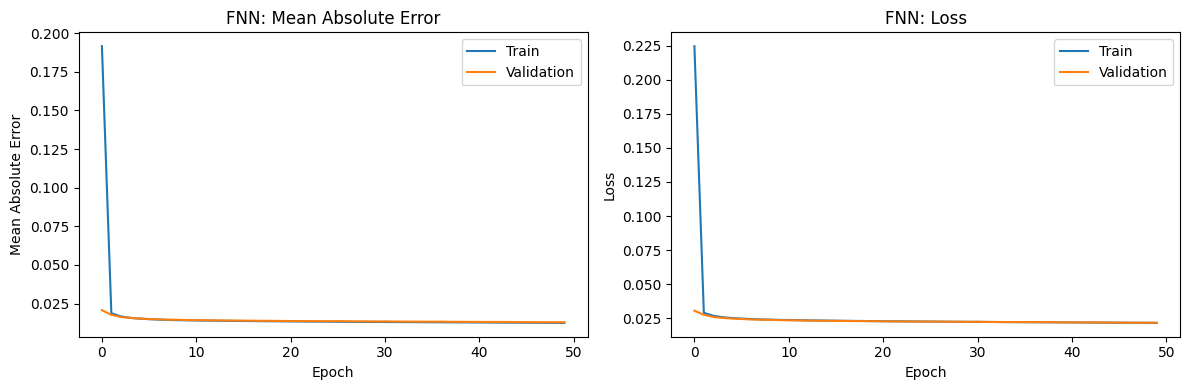

[20:43:23] ======== Monitor (0): HostSketchContainer ========
[20:43:23] AllReduce: 0.006974s, 1 calls @ 6974us

[20:43:23] MakeCuts: 0.007014s, 1 calls @ 7014us

[20:43:23] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[20:43:23] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:744: [GPU Hist]: Configure
[20:43:23] ======== Monitor (0):  ========
[20:43:23] InitCompressedData: 0.000335s, 1 calls @ 335us

[20:43:29] ======== Monitor (0): Learner ========
[20:43:29] Configure: 0.001331s, 1 calls @ 1331us

[20:43:29] EvalOneIter: 0.001606s, 250 calls @ 1606us

[20:43:29] GetGradient: 2.69947s, 250 calls @ 2699465us

[20:43:29] PredictRaw: 0.000491s, 250 calls @ 491us

[20:43:29] UpdateOneIter: 5.37088s, 250 calls @ 5370879us

[20:43:29] ======== Monitor (0): GBTree ========
[20:43:29] BoostNewTrees: 2.56566s, 250 calls @ 2565663us

[20:43:29] CommitModel: 0.000144s, 250 calls @ 144us

[20:43:29] ======== Device 0 Memory Allocations:  ========
[20:43:29] Peak memory usage: 2

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 128)               1152      
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dense_17 (Dense)            (None, 32)                2080      
                                                                 
 dense_18 (Dense)            (None, 16)                528       
                                                                 
 dense_19 (Dense)            (None, 2)                 34        
                                                                 
Total params: 12050 (47.07 KB)
Trainable params: 12050 (47.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
1620/16

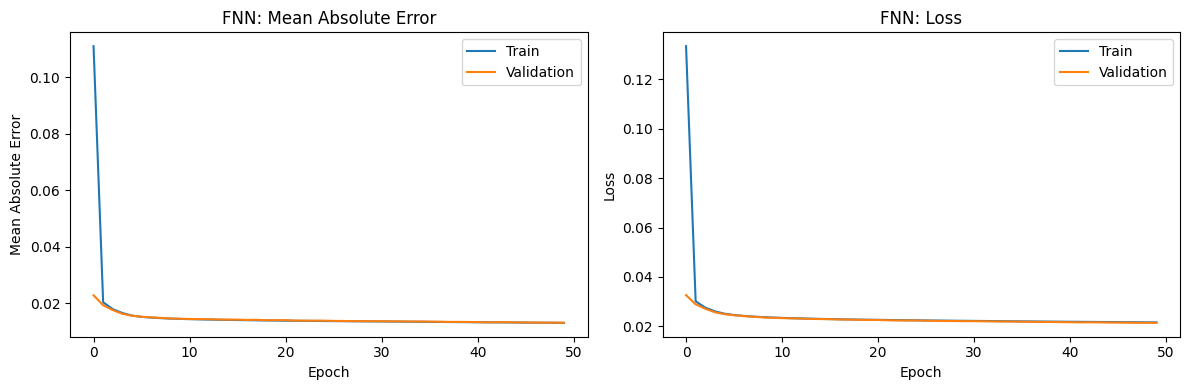

[21:09:18] ======== Monitor (0): HostSketchContainer ========
[21:09:18] AllReduce: 0.004759s, 1 calls @ 4759us

[21:09:18] MakeCuts: 0.004794s, 1 calls @ 4794us

[21:09:18] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[21:09:18] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:744: [GPU Hist]: Configure
[21:09:18] ======== Monitor (0):  ========
[21:09:18] InitCompressedData: 0.000353s, 1 calls @ 353us

[21:09:24] ======== Monitor (0): Learner ========
[21:09:24] Configure: 0.000797s, 1 calls @ 797us

[21:09:24] EvalOneIter: 0.00156s, 250 calls @ 1560us

[21:09:24] GetGradient: 2.66475s, 250 calls @ 2664746us

[21:09:24] PredictRaw: 0.000495s, 250 calls @ 495us

[21:09:24] UpdateOneIter: 5.32568s, 250 calls @ 5325684us

[21:09:24] ======== Monitor (0): GBTree ========
[21:09:24] BoostNewTrees: 2.55513s, 250 calls @ 2555133us

[21:09:24] CommitModel: 0.00012s, 250 calls @ 120us

[21:09:24] ======== Device 0 Memory Allocations:  ========
[21:09:24] Peak memory usage: 242M

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.00566 | val_0_rmse: 0.0227  |  0:01:24s
epoch 1  | loss: 0.00059 | val_0_rmse: 0.02263 |  0:02:48s
epoch 2  | loss: 0.00054 | val_0_rmse: 0.02248 |  0:04:13s
epoch 3  | loss: 0.00053 | val_0_rmse: 0.02233 |  0:05:39s
epoch 4  | loss: 0.00051 | val_0_rmse: 0.02215 |  0:07:04s
epoch 5  | loss: 0.0005  | val_0_rmse: 0.02197 |  0:08:29s
epoch 6  | loss: 0.00048 | val_0_rmse: 0.02147 |  0:09:54s
epoch 7  | loss: 0.00049 | val_0_rmse: 0.02187 |  0:11:19s
epoch 8  | loss: 0.00047 | val_0_rmse: 0.02155 |  0:12:44s
epoch 9  | loss: 0.00047 | val_0_rmse: 0.02142 |  0:14:09s
Stop training because you reached max_epochs = 10 with best_epoch = 9 and best_val_0_rmse = 0.02142


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [35]:
# Call train models function on each k fold
model_dictionary = dict()
for i in range(index+1):
  X_train_index = X_train_indices_dict[i]
  X_val_index = X_val_indices_dict[i]
  X_test_index = X_test_indices_dict[i]
  X_train = X_selected[X_train_index]
  y_train = y_selected[X_train_index]
  X_val = X_selected[X_val_index]
  y_val = y_selected[X_val_index]
  X_test = X_selected[X_test_index]
  y_test = y_selected[X_test_index]
  X_train = X_train.astype(float)
  y_train = y_train.astype(float)
  X_val = X_val.astype(float)
  y_val = y_val.astype(float)
  X_test = X_test.astype(float)
  y_test = y_test.astype(float)

  nn_model, xgb_model, tabnet_model = train_models(X_train,y_train,X_val,y_val)
  model_dictionary[i] = [nn_model,xgb_model,tabnet_model]


# EVALUATION SIMULATION TEST DATA

In [36]:
# Evaluation tables simulated data
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
names = ['Permittivity_Real', 'Permittivity_Imaginary']
model_names = ["FNN","XGBoost","TabNet"]
num_models = len(model_dictionary)
num_targets = 2
y_pred_models = [[] for _ in range(num_models)]
y_test_targets = [[] for _ in range(num_targets)]
for i in range(num_models):
    nn_model, xgb_model, tabnet_model = model_dictionary[i]
    y_pred_nn = np.mean(nn_model.predict(X_test).reshape(-1,1001,2),axis=1)
    y_pred_nn[:,0] = y_pred_nn[:,0] * 100
    y_pred_xgb = np.mean(xgb_model.predict(X_test).reshape(-1,1001,2),axis=1)
    y_pred_xgb[:,0] = y_pred_xgb[:,0] * 100
    y_pred_tab = np.mean(tabnet_model.predict(X_test).reshape(-1,1001,2),axis=1)
    y_pred_tab[:,0] = y_pred_tab[:,0] * 100
    y_pred_models[i] = [y_pred_nn, y_pred_xgb, y_pred_tab]
    y_test_targets[0] = np.mean(y_test[:, 0].reshape(-1,1001),axis=1) * 100
    y_test_targets[1] = np.mean(y_test[:, 1].reshape(-1,1001),axis=1)
for t in range(num_targets):
    metrics_data = []
    y_test_target = y_test_targets[t]
    target_data = {
        "Target": names[t]
    }
    for model_type in range(len(y_pred_models[0])):
        mean = np.zeros_like(y_pred_models[0][model_type][:, t])
        squared_diff_sum = np.zeros_like(y_pred_models[0][model_type][:, t])
        for k_fold in range(len(y_pred_models)):
            y_pred_fold = y_pred_models[k_fold][model_type][:, t]
            mean += y_pred_fold
            squared_diff_sum += (y_pred_fold - mean) ** 2
        mean = mean / len(y_pred_models)
        std_deviation = np.sqrt(squared_diff_sum / len(y_pred_models))
        mse = mean_squared_error(y_test_target, mean)
        mae = mean_absolute_error(y_test_target, mean)
        rmse = np.sqrt(mse)
        r_squared = r2_score(y_test_target, mean)
        target_data[f"Mean ({model_names[model_type]})"] = mean
        target_data[f"SD ({model_names[model_type]})"] = std_deviation
        target_data[f"MSE ({model_names[model_type]})"] = mse
        target_data[f"MAE ({model_names[model_type]})"] = mae
        target_data[f"RMSE ({model_names[model_type]})"] = rmse
        target_data[f"R² ({model_names[model_type]})"] = r_squared

    metrics_data.append(target_data)
    metrics_df = pd.DataFrame(metrics_data)
    display(metrics_df)

6288/6288 [==============================] - 38s 6ms/step
[21:26:34] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[21:26:34] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:744: [GPU Hist]: Configure


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [21:26:34] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


6288/6288 [==============================] - 35s 6ms/step
[21:27:19] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[21:27:19] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:744: [GPU Hist]: Configure
6288/6288 [==============================] - 32s 5ms/step
[21:28:01] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[21:28:01] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:744: [GPU Hist]: Configure
6288/6288 [==============================] - 36s 6ms/step
[21:28:47] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[21:28:47] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:744: [GPU Hist]: Configure


,Target,Mean (FNN),SD (FNN),MSE (FNN),MAE (FNN),RMSE (FNN),R² (FNN),Mean (XGBoost),SD (XGBoost),MSE (XGBoost),MAE (XGBoost),RMSE (XGBoost),R² (XGBoost),Mean (TabNet),SD (TabNet),MSE (TabNet),MAE (TabNet),RMSE (TabNet),R² (TabNet)
0,Permittivity_Real,"[1.226271, 7.930952, 7.4290886, 6.9276514, 5.9...","[2.3264346, 14.987247, 13.994014, 13.074572, 1...",0.135839,0.268564,0.368564,0.971096,"[1.3210931, 8.233148, 7.4819565, 6.9533195, 5....","[2.4722033, 15.398713, 13.993051, 13.006527, 1...",0.109035,0.249522,0.330205,0.976799,"[1.9117138, 7.8938613, 7.3603373, 6.968379, 5....","[3.5838547, 14.7514515, 13.778556, 13.07198, 1...",0.218388,0.391796,0.46732,0.95353


,Target,Mean (FNN),SD (FNN),MSE (FNN),MAE (FNN),RMSE (FNN),R² (FNN),Mean (XGBoost),SD (XGBoost),MSE (XGBoost),MAE (XGBoost),RMSE (XGBoost),R² (XGBoost),Mean (TabNet),SD (TabNet),MSE (TabNet),MAE (TabNet),RMSE (TabNet),R² (TabNet)
0,Permittivity_Imaginary,"[0.047212996, 0.03937146, 0.045656428, 0.04243...","[0.08870587, 0.07292706, 0.08469621, 0.0786819...",0.000552,0.02062,0.023496,0.355554,"[0.048453577, 0.030561902, 0.04489419, 0.04130...","[0.090699494, 0.05702089, 0.08367679, 0.077162...",0.000483,0.019144,0.021968,0.436652,"[0.049298637, 0.050101783, 0.05007772, 0.05000...","[0.09298056, 0.09325053, 0.093261726, 0.093186...",0.000854,0.025922,0.029226,0.002843


6288/6288 [==============================] - 33s 5ms/step


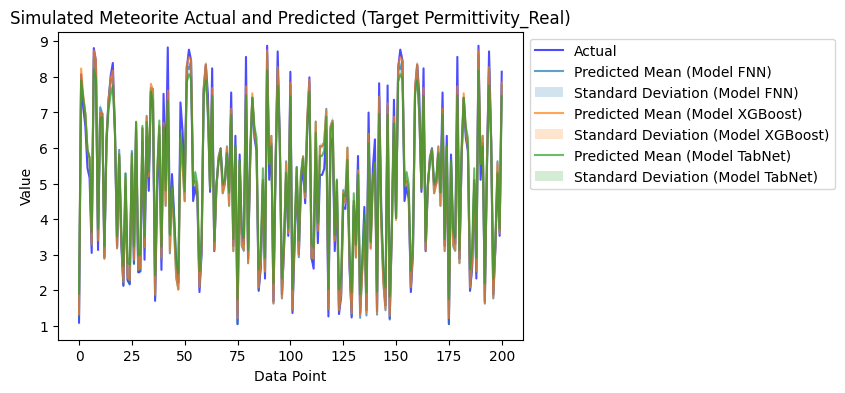

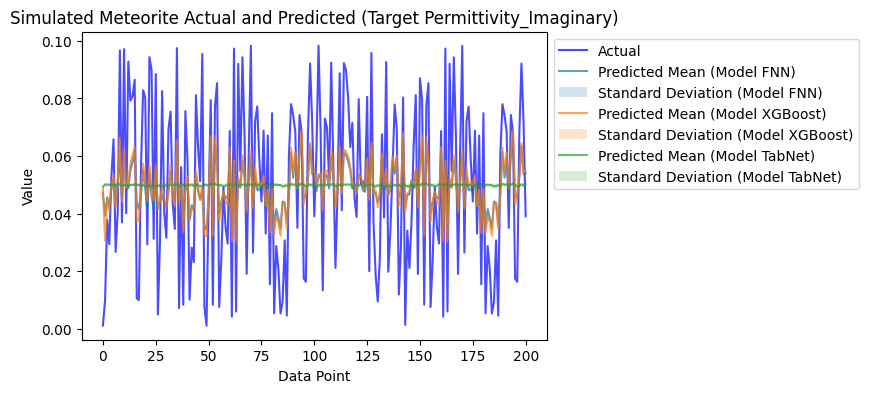

In [37]:
# Evaluation plots simulated data
names = ['Permittivity_Real', 'Permittivity_Imaginary']
model_names = ["FNN","XGBoost","TabNet"]
num_models = len(model_dictionary)
num_targets = 2
y_pred_models = [[] for _ in range(num_models)]
y_test_targets = [[] for _ in range(num_targets)]
for i in range(num_models):
    nn_model, xgb_model, tabnet_model = model_dictionary[i]
    y_pred_nn = np.mean(nn_model.predict(X_test).reshape(-1,1001,2),axis=1)
    y_pred_nn[:,0] = y_pred_nn[:,0] * 100
    y_pred_xgb = np.mean(xgb_model.predict(X_test).reshape(-1,1001,2),axis=1)
    y_pred_xgb[:,0] = y_pred_xgb[:,0] * 100
    y_pred_tab = np.mean(tabnet_model.predict(X_test).reshape(-1,1001,2),axis=1)
    y_pred_tab[:,0] = y_pred_tab[:,0] * 100
    y_pred_models[i] = [y_pred_nn, y_pred_xgb, y_pred_tab]
    y_test_targets[0] = np.mean(y_test[:, 0].reshape(-1,1001),axis=1) * 100
    y_test_targets[1] = np.mean(y_test[:, 1].reshape(-1,1001),axis=1)
for t in range(num_targets):
  y_test_target = y_test_targets[t]
  plt.figure(figsize=(6, 4))
  plt.plot(range(len(y_test_target)), y_test_target, label='Actual', color='blue', alpha=0.7)
  for model_type in range(len(y_pred_models[0])):
    mean = np.zeros_like(y_pred_models[0][model_type][:, t])
    squared_diff_sum = np.zeros_like(y_pred_models[0][model_type][:, t])
    for k_fold in range(len(y_pred_models)):
      y_pred_fold = y_pred_models[k_fold][model_type][:, t]
      mean += y_pred_fold
    mean = mean / len(y_pred_models)
    for k_fold in range(len(y_pred_models)):
      y_pred_fold = y_pred_models[k_fold][model_type][:, t]
      squared_diff_sum += (y_pred_fold - mean) ** 2
    std_deviation = np.sqrt(squared_diff_sum / len(y_pred_models))
    std_deviation = np.sqrt(squared_diff_sum / len(y_pred_models))
    plt.plot(range(len(y_test_target)), mean, label=f'Predicted Mean (Model {model_names[model_type]})', alpha=0.7)
    plt.fill_between(range(len(y_test_target)), mean - std_deviation, mean + std_deviation, alpha=0.2, label=f'Standard Deviation (Model {model_names[model_type]})')
  plt.title(f'Simulated Meteorite Actual and Predicted (Target {names[t]})')
  plt.xlabel('Data Point')
  plt.ylabel('Value')
  plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
  plt.show()

# EVALUATION ACTUAL TEST DATA

In [38]:
X_test = testing_dataframe[columns].values
y_test = testing_dataframe[['Permittivity_Real', 'Permittivity_Imaginary']].values

In [39]:
# Evaluation tables actual data
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
names = ['Permittivity_Real', 'Permittivity_Imaginary']
model_names = ["FNN","XGBoost","TabNet"]
num_models = len(model_dictionary)
num_targets = 2
y_pred_models = [[] for _ in range(num_models)]
y_test_targets = [[] for _ in range(num_targets)]
for i in range(num_models):
    nn_model, xgb_model, tabnet_model = model_dictionary[i]
    y_pred_nn = np.mean(nn_model.predict(X_test).reshape(-1,1001,2),axis=1)
    y_pred_nn[:,0] = y_pred_nn[:,0] * 100
    y_pred_xgb = np.mean(xgb_model.predict(X_test).reshape(-1,1001,2),axis=1)
    y_pred_xgb[:,0] = y_pred_xgb[:,0] * 100
    y_pred_tab = np.mean(tabnet_model.predict(X_test).reshape(-1,1001,2),axis=1)
    y_pred_tab[:,0] = y_pred_tab[:,0] * 100
    y_pred_models[i] = [y_pred_nn, y_pred_xgb, y_pred_tab]
    y_test_targets[0] = np.mean(y_test[:, 0].reshape(-1,1001),axis=1) * 100
    y_test_targets[1] = np.mean(y_test[:, 1].reshape(-1,1001),axis=1)
for t in range(num_targets):
    metrics_data = []
    y_test_target = y_test_targets[t]
    target_data = {
        "Target": names[t]
    }
    for model_type in range(len(y_pred_models[0])):
        mean = np.zeros_like(y_pred_models[0][model_type][:, t])
        squared_diff_sum = np.zeros_like(y_pred_models[0][model_type][:, t])
        for k_fold in range(len(y_pred_models)):
            y_pred_fold = y_pred_models[k_fold][model_type][:, t]
            mean += y_pred_fold
            squared_diff_sum += (y_pred_fold - mean) ** 2
        mean = mean / len(y_pred_models)
        std_deviation = np.sqrt(squared_diff_sum / len(y_pred_models))
        mse = mean_squared_error(y_test_target, mean)
        mae = mean_absolute_error(y_test_target, mean)
        rmse = np.sqrt(mse)
        r_squared = r2_score(y_test_target, mean)
        target_data[f"Mean ({model_names[model_type]})"] = mean
        target_data[f"SD ({model_names[model_type]})"] = std_deviation
        target_data[f"MSE ({model_names[model_type]})"] = mse
        target_data[f"MAE ({model_names[model_type]})"] = mae
        target_data[f"RMSE ({model_names[model_type]})"] = rmse
        target_data[f"R² ({model_names[model_type]})"] = r_squared

    metrics_data.append(target_data)
    metrics_df = pd.DataFrame(metrics_data)
    display(metrics_df)

126/126 [==============================] - 0s 1ms/step


,Target,Mean (FNN),SD (FNN),MSE (FNN),MAE (FNN),RMSE (FNN),R² (FNN),Mean (XGBoost),SD (XGBoost),MSE (XGBoost),MAE (XGBoost),RMSE (XGBoost),R² (XGBoost),Mean (TabNet),SD (TabNet),MSE (TabNet),MAE (TabNet),RMSE (TabNet),R² (TabNet)
0,Permittivity_Real,"[4.9646583, 5.5246925, 4.9246683, 5.5345774]","[7.869646, 8.564607, 7.8065734, 8.60349]",6.451434,2.512851,2.539967,-33.407649,"[7.009429, 8.076754, 6.972565, 8.028368]","[13.007445, 14.976421, 12.940763, 14.882782]",0.265602,0.285496,0.515366,-0.416543,"[6.1354, 7.142061, 6.099071, 7.105197]","[11.313408, 13.117522, 11.245729, 13.049132]",1.474449,1.129568,1.214269,-6.863728


,Target,Mean (FNN),SD (FNN),MSE (FNN),MAE (FNN),RMSE (FNN),R² (FNN),Mean (XGBoost),SD (XGBoost),MSE (XGBoost),MAE (XGBoost),RMSE (XGBoost),R² (XGBoost),Mean (TabNet),SD (TabNet),MSE (TabNet),MAE (TabNet),RMSE (TabNet),R² (TabNet)
0,Permittivity_Imaginary,"[0.14559047, 0.15155314, 0.14542012, 0.15182954]","[0.29907724, 0.311363, 0.29905996, 0.31181103]",0.193738,0.294197,0.440157,-0.703942,"[0.20530304, 0.2449851, 0.20404397, 0.24094741]","[0.37029374, 0.44965944, 0.36789975, 0.44204956]",0.161834,0.248832,0.402286,-0.423343,"[0.0524763, 0.052350268, 0.052473135, 0.05240135]","[0.09856591, 0.09829298, 0.098558635, 0.098415...",0.256251,0.377575,0.506212,-1.253743


126/126 [==============================] - 3s 23ms/step


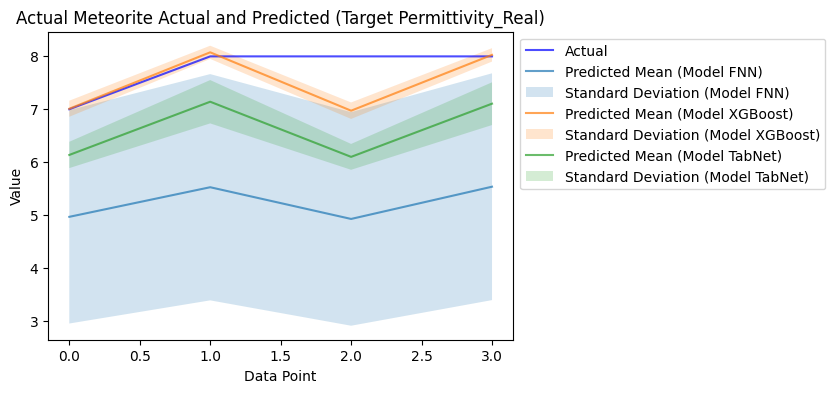

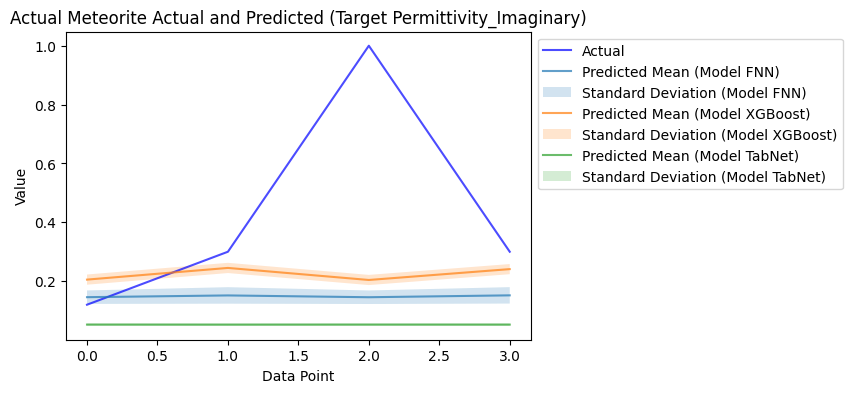

In [40]:
# Evaluation plots actual data
names = ['Permittivity_Real', 'Permittivity_Imaginary']
model_names = ["FNN","XGBoost","TabNet"]
num_models = len(model_dictionary)
num_targets = 2
y_pred_models = [[] for _ in range(num_models)]
y_test_targets = [[] for _ in range(num_targets)]
for i in range(num_models):
    nn_model, xgb_model, tabnet_model = model_dictionary[i]
    y_pred_nn = np.mean(nn_model.predict(X_test).reshape(-1,1001,2),axis=1)
    y_pred_nn[:,0] = y_pred_nn[:,0] * 100
    y_pred_xgb = np.mean(xgb_model.predict(X_test).reshape(-1,1001,2),axis=1)
    y_pred_xgb[:,0] = y_pred_xgb[:,0] * 100
    y_pred_tab = np.mean(tabnet_model.predict(X_test).reshape(-1,1001,2),axis=1)
    y_pred_tab[:,0] = y_pred_tab[:,0] * 100
    y_pred_models[i] = [y_pred_nn, y_pred_xgb, y_pred_tab]
    y_test_targets[0] = np.mean(y_test[:, 0].reshape(-1,1001),axis=1) * 100
    y_test_targets[1] = np.mean(y_test[:, 1].reshape(-1,1001),axis=1)
for t in range(num_targets):
  y_test_target = y_test_targets[t]
  plt.figure(figsize=(6, 4))
  plt.plot(range(len(y_test_target)), y_test_target, label='Actual', color='blue', alpha=0.7)
  for model_type in range(len(y_pred_models[0])):
    mean = np.zeros_like(y_pred_models[0][model_type][:, t])
    squared_diff_sum = np.zeros_like(y_pred_models[0][model_type][:, t])
    for k_fold in range(len(y_pred_models)):
      y_pred_fold = y_pred_models[k_fold][model_type][:, t]
      mean += y_pred_fold
    mean = mean / len(y_pred_models)
    for k_fold in range(len(y_pred_models)):
      y_pred_fold = y_pred_models[k_fold][model_type][:, t]
      squared_diff_sum += (y_pred_fold - mean) ** 2
    std_deviation = np.sqrt(squared_diff_sum / len(y_pred_models))
    std_deviation = np.sqrt(squared_diff_sum / len(y_pred_models))
    plt.plot(range(len(y_test_target)), mean, label=f'Predicted Mean (Model {model_names[model_type]})', alpha=0.7)
    plt.fill_between(range(len(y_test_target)), mean - std_deviation, mean + std_deviation, alpha=0.2, label=f'Standard Deviation (Model {model_names[model_type]})')
  plt.title(f'Actual Meteorite Actual and Predicted (Target {names[t]})')
  plt.xlabel('Data Point')
  plt.ylabel('Value')
  plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
  plt.show()